# <center>Fantasy EPL Project</center>

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

### Appending Function to Update Database 

In [2]:
df_league_wide_OUT = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\OUT\W3OUT_Appended.csv')
df_league_wide_OUT_NEW = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\OUT\W4OUT.csv')

df_league_wide_GK = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\GK\W3GK_Appended.csv')
df_league_wide_GK_NEW = (r'C:\Users\Alfonso\Desktop\Coding\FantasyEPL\League_Wide\GK\W4GK.csv')

In [3]:
def clean_league_wide(csv_file):
    """
    Basic data cleaning function: changes index, renames columns and deletes unwated ones, 
    adds a 'Matchday' column and cleans 'Opponent' column values.
    """
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['Rk']).set_index('Rk') #Sets the player column as the new index (instead of numbered values)
    df.rename({'Position': 'Pos', 'Status' : 'Owner'}, axis=1, inplace=True)    
    df.drop(['% Owned', 'Roster Status','+/-'], axis=1, inplace=True)
    df['Opponent'] = df['Opponent'].apply(lambda x: x.strip('@')[0:3]) #Removes '@' and  game time(keeps only opponent team name) 
    df['Matchday'] = 1 #sets matchday column
    return df

In [4]:
def append_dataframes(old_df, new_df):
    """
    Appending Function: Takes new dataframe and cleans it, then appends it with the previous weeks 
    dataframe and correctly updates the 'Matchday' values for newly added data.
    """
    old_df = pd.read_csv(old_df)
    new_df = clean_league_wide(new_df)
    new_df['Matchday'] = (old_df['Matchday'].iloc[-1] + 1)
    old_df = old_df.dropna(subset=['Rk']).set_index('Rk') #Sets the player column as the new index (instead of numbered values)
    new_df = old_df.append(new_df) 
    new_df.drop(['FP/G'], axis=1, inplace=True)
    return new_df

df_appended_GK = append_dataframes(df_league_wide_GK, df_league_wide_GK_NEW)
df_appended_OUT = append_dataframes(df_league_wide_OUT, df_league_wide_OUT_NEW)

### Saving Dataframes Function

In [14]:
def save_cleaned_files(df, name):
    df.to_csv(R'C:\\Users\\Alfonso\\Desktop\\Coding\\FantasyEPL\\'+ name + '.csv')

#save_cleaned_files(df_appended_OUT, 'W4OUT_Appended')

### Splitting dataframes based on position and attacking/defensive scoring

In [5]:
gk_df = df_appended_GK[df_appended_GK['Pos'] == 'G']
d_df = df_appended_OUT[df_appended_OUT['Pos'] == 'D']
m_df = df_appended_OUT[df_appended_OUT['Pos'] == 'M']
f_df = df_appended_OUT[df_appended_OUT['Pos'] == 'F']

In [6]:
attacking_columns = ['G','KP','AT','SOT','CoS','ACNC']
defensive_columns = ['TkW','Int','CLR','AER','CS']
malus_columns = ['PKM','OG','GAO','YC','RC','DIS']

def transform_columns(df,new_column_list):
    df = df[['Player','Pos','Team','Owner', 'Opponent', 'FPts', 'GP'] + new_column_list + ['Matchday']]
    return df

In [7]:
defensive_stats_df = transform_columns(df_appended_OUT,defensive_columns)
attacking_stats_df = transform_columns(df_appended_OUT,attacking_columns)
malus_stats_df = transform_columns(df_appended_OUT,malus_columns)

### Team of the Week Creator

In [193]:
MATCH_DAY = 4

def create_GK_TOTW(database_GK,sorting_value,matchday):
    database_GK=database_GK.loc[database_GK['Matchday'] == matchday].sort_values(sorting_value,ascending=False)[:1]
    return database_GK

def create_OUT_TOTW(database_OUT, sorting_value,matchday):
    """
    Function that filters the appended database by selected Matchday, and returns the 10 highest scoring 
    Outfield players, keeping the following paramenters true: 3 Forwards, 3/4 Midfielders, 3/4 Defenders.
    """
    df=database_OUT.loc[database_OUT['Matchday'] == matchday].sort_values(sorting_value,ascending=False)
    D=0 ; M=0 ; F=0  
    for index, row in df.iterrows():
        if row['Pos'] == 'D':
            D += 1
            if D == 4 and M >= 3 or D >= 5:
                df=df.drop(index)
        elif row['Pos'] == 'M':
            M += 1
            if M == 4 and D >= 3 or M >= 5:
                df=df.drop(index)
        elif row['Pos'] == 'F':
            F += 1
            if F > 3:
                df=df.drop(index)    
    return df

df_TOTW_GK = create_GK_TOTW(gk_df,'FPts', MATCH_DAY )
df_TOTW_OUT = create_OUT_TOTW(df_appended_OUT,'FPts', MATCH_DAY )

In [191]:
df_TOTW_GK

,Player,Team,Pos,Owner,Opponent,FPts,GP,CS,GA,Sv,YC,RC,PKS,PKM,TkW,DIS,G,KP,AT,Int,CLR,CoS,AER,AC,OG,SOT,Matchday
Rk,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Alex McCarthy,SOU,G,KPR,WBA,14.25,1,1,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,4


In [192]:
df_TOTW_OUT 

,Player,Team,Pos,Owner,Opponent,FPts,GP,G,KP,AT,SOT,TkW,DIS,YC,RC,ACNC,Int,CLR,CoS,AER,PKM,OG,GAO,CS,Matchday
Rk,,,,,,,,,,,,,,,,,,,,,,,,,
1,Jack Grealish,AVL,M,CIU,LIV,54.50,1,2,5,3,2,3,0,0,0,0,1,1,0,1,0,0,2,0,4
2,Ollie Watkins,AVL,F,CIU,LIV,46.50,1,3,2,1,4,0,3,0,0,0,1,0,1,2,0,0,2,0,4
3,Ben Chilwell,CHE,D,MoM,CRY,39.25,1,1,3,1,1,0,0,0,0,3,3,1,0,2,0,0,0,1,4
4,Son Heung-Min,TOT,F,CIU,TOT,37.50,1,2,5,1,2,0,2,0,0,0,0,0,0,1,0,0,1,0,4
5,Harry Kane,TOT,F,MoM,TOT,36.50,1,2,3,1,3,0,1,0,0,0,1,0,0,0,0,0,1,0,4
6,James Rodriguez,EVE,M,Cavleti,BHA,36.50,1,2,2,1,2,2,3,0,0,1,1,0,2,0,0,0,1,0,4
9,Allan Saint-Maximin,NEW,M,Cavleti,BUR,27.50,1,1,3,1,1,0,1,0,0,1,0,0,4,0,0,0,1,0,4
10,John McGinn,AVL,M,MoM,LIV,26.00,1,1,1,1,1,1,2,0,0,0,3,2,4,0,0,0,2,0,4
16,Yerry Mina,EVE,D,Cavleti,BHA,18.00,1,1,0,0,1,1,0,0,0,0,4,4,0,4,0,0,2,0,4


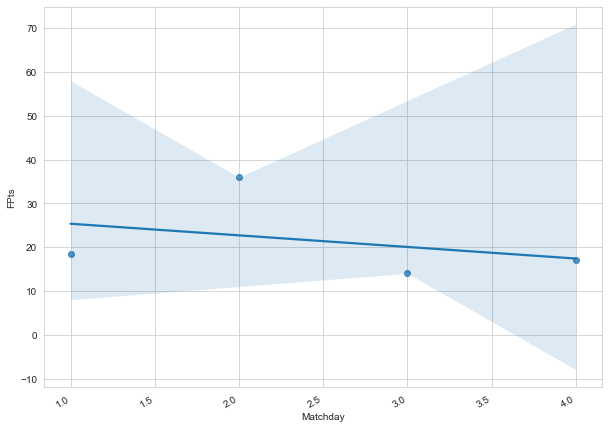

In [152]:
df_Player_Analysis = df_appended_OUT[(df_appended_OUT['Player'] == 'Dominic Calvert-Lewin')]
sns.set_style('whitegrid')

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')

plot = sns.regplot(x= df_Player_Analysis['Matchday'] , y= df_Player_Analysis['FPts'], scatter=True)

(0.75, 4.25)

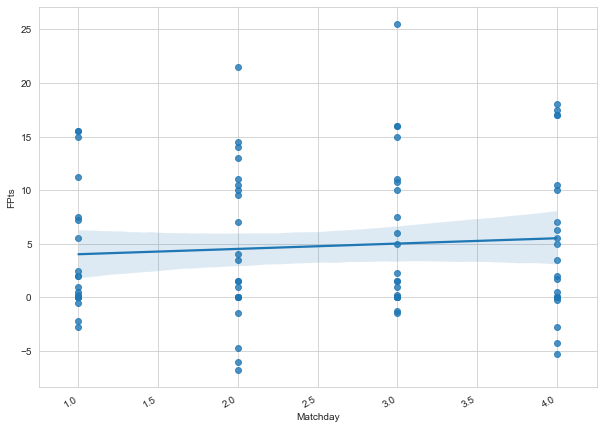

In [168]:
df_Team_Analysis = df_appended_OUT[(df_appended_OUT['Owner'] == 'LEEDS')]
sns.set_style('whitegrid')

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xlim(0.75, df_appended_OUT['Matchday'].iloc[-1]+0.25)
plot = sns.regplot(x= df_Team_Analysis['Matchday'] , y= df_Team_Analysis['FPts'], scatter=True)
plt.xlim(0.75, df_appended_OUT['Matchday'].iloc[-1]+0.25)

(0.75, 4.25)

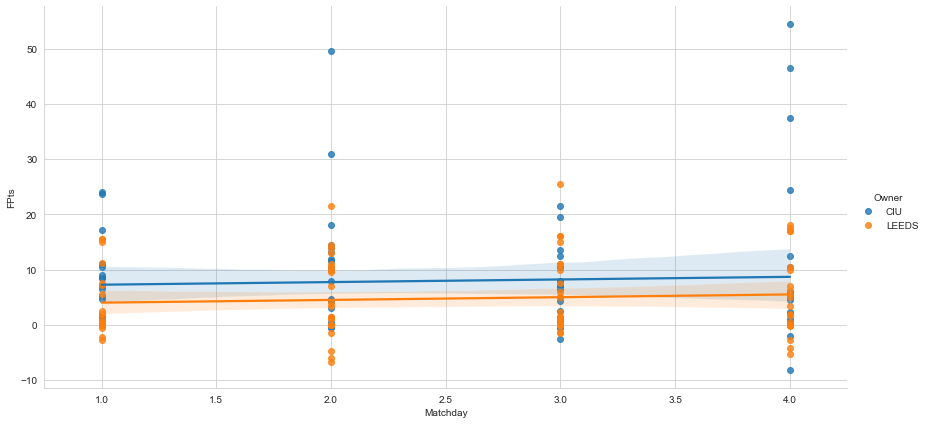

In [209]:
df_team_comparison=df_appended_OUT.loc[(df_appended_OUT['Owner'] == 'LEEDS') | (df_appended_OUT['Owner'] == 'CIU')]
sns.lmplot(x= 'Matchday', y= 'FPts',hue= 'Owner',data=df_team_comparison, height=6, aspect=2) 
plt.xlim(0.75, df_appended_OUT['Matchday'].iloc[-1]+0.25)

(0.75, 5)

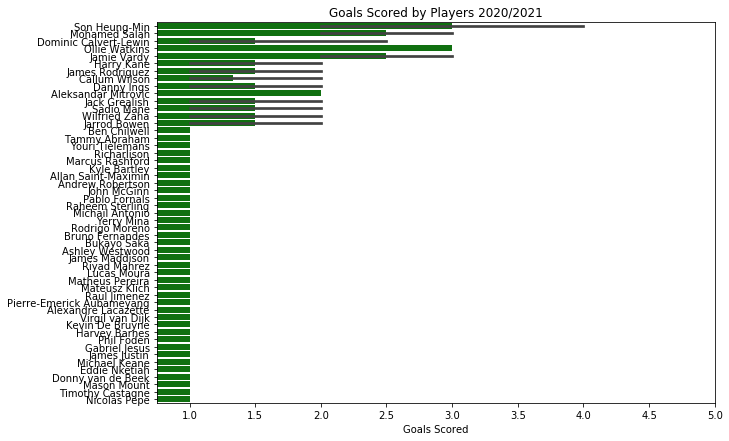

In [168]:
df_Goals=df_appended_OUT[(df_appended_OUT['G'] >= 1)]

fig, ax = plt.subplots()
fig.set_size_inches(10,7)
plot=sns.barplot(
    x='G', 
    y='Player',
    data=df_Goals.sort_values('G',
    ascending=False),
    color="g",)
plt.xlabel("Goals Scored"),
plt.ylabel("")
plt.title("Goals Scored by Players 2020/2021")
plt.xlim(0.75, df_appended_OUT['G'].max()+1)